step 1: elapsed 0.818718433380127
step 2: elapsed 0.0077686309814453125
step 3: elapsed 0.010017156600952148
step 4: elapsed 0.35116076469421387
step 5: elapsed 0.0017859935760498047
step 5: elapsed 0.0019488334655761719
elapsed 1.1931991577148438


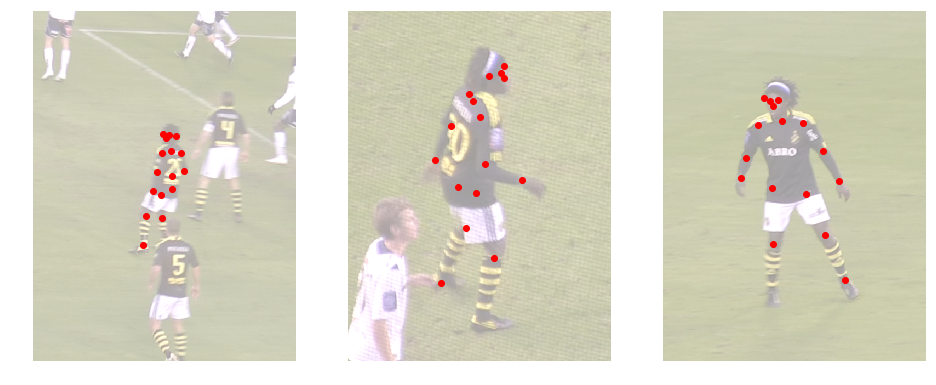

In [17]:
%matplotlib inline
# ---- settings ----
import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
sys.path.insert(0, '../'); sys.path.insert(0, '.')

import numpy as np
import mvpose.data.kth_football2 as kth
from mvpose import pose
import paf_loader
from time import time

from mvpose.algorithm import settings
import mvpose.data.skeleton_augmentation as ska
from mvpose.algorithm.candidate_selection import project_human_to_2d

params = settings.get_settings(scale_to_mm=1000)

FRAME = 10
data_root = Settings['data_root']
seq1_zipname = 'player1sequence2.zip'
seq1_dir = 'Sequence 2'
Im, Calib, pos2d, pos3d = kth.get(data_root, seq1_zipname, seq1_dir, 
                                  FRAME)

heatmaps, pafs = paf_loader.load_confidence_map_and_paf(
    'kth' + seq1_zipname[0:-4], Im, FRAME)
_start = time()
Debug, detections = pose.estimate_heuristic(Calib, heatmaps, pafs,
                                  settings=params, debug=True)
_end = time()
print('elapsed', _end - _start)

Humans = detections

fig = plt.figure(figsize=(16,12))

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(1,3,1+idx)
    ax.axis('off')
    im = Im[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.4)
    
    for pid, human in enumerate(Humans):
        human2d = project_human_to_2d(human, cam)
        for p in human2d:
            if p is not None:
                ax.scatter(p[0], p[1], color='red')
    
plt.show()

elapsed 1.9769904613494873


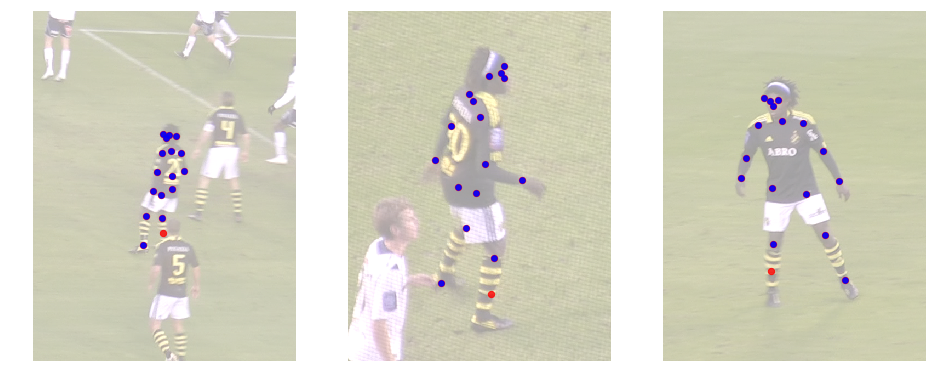

In [20]:
model_path = '../data/model_poseprediction.h5'

_start = time()
gen = ska.LimbGenerator(model_path, params.scale_to_mm)
_end = time()
print('elapsed', _end - _start)

humans = gen.apply(Humans)

fig = plt.figure(figsize=(16,12))
for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(1,3,1+idx)
    ax.axis('off')
    im = Im[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.4)
    
    for pid, human in enumerate(humans):
        human2d = project_human_to_2d(human, cam)
        for p in human2d:
            if p is not None:
                ax.scatter(p[0], p[1], color='red', alpha=0.8, s=40)
    
    for pid, human in enumerate(Humans):
        human2d = project_human_to_2d(human, cam)
        for p in human2d:
            if p is not None:
                ax.scatter(p[0], p[1], color='blue', alpha=0.9, s=30)
    
    
plt.show()